# Investigating the benefit of using undersampling with a basic CNN to identify COVID-19 from coughs

Model reads in image files that have been created from cough audio files.
Machine learning is applied to create a classifier. The aim of undersampling is to reduce the examples of the majority class in order to balance the dataset.

This Model uses ImageDataGenerator

Mounting the Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## Upload images to pandas dataframe and visualize a few images.

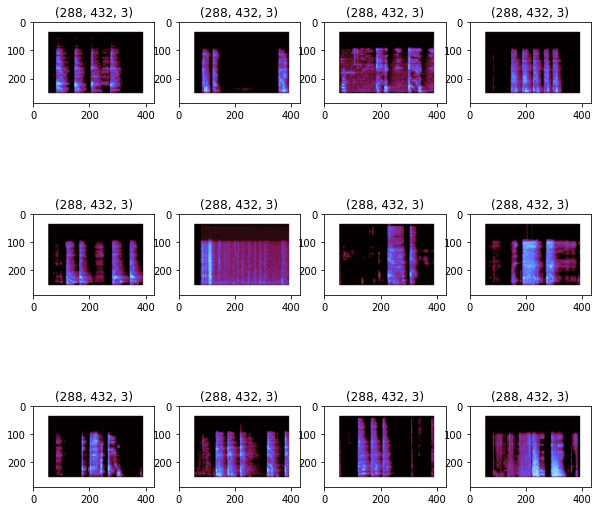

In [ ]:
# Always run this code.
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from contextlib import redirect_stdout
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from sklearn.metrics import roc_curve

folder = '/content/drive/My Drive/Colab Notebooks/COVID-19'
if not os.path.exists(folder):
  print(folder + ' does not exist')


df_images = pd.read_csv(os.path.join(folder, 'df_train.csv'), index_col=0)

fnames = df_images.loc[:,'image_file']

plt.figure(figsize=(10,10))
for i in range(12): 
    plt.subplot(3,4,i+1)
    
    filename = fnames[i]
    if not os.path.exists(filename):
      print ('No such file:'+filename)
    
    image = imread(filename)
    plt.title(image.shape)
    plt.imshow(image)
    
plt.show()


In [ ]:
pd.set_option('max_columns', None)
print(df_images.shape)
print(df_images.head(5))

(11401, 8)
                                     id   age  gender    status  \
0          Zb2Inq1UVhcMnWA41GpKyRdF4z62  66.0  female   healthy   
1  c4138919-bd2c-4e24-9fcf-582e428c7d27  37.0  female   healthy   
2          ygiPwZYsKFetOejhxWXB6rKSHAf2  66.0    male  COVID-19   
3  ec8ddd1e-d555-490f-9719-70a99c1c6993  29.0    male   healthy   
4          CFkIEzwZ5PcogCElOD2K3RJQzmh1  44.0    male   healthy   

                                          audio_file  \
0  /content/drive/My Drive/Colab Notebooks/coswar...   
1  /content/drive/My Drive/Colab Notebooks/coughv...   
2  /content/drive/My Drive/Colab Notebooks/coswar...   
3  /content/drive/My Drive/Colab Notebooks/coughv...   
4  /content/drive/My Drive/Colab Notebooks/coswar...   

                                          image_file    source  cough_detected  
0  /content/drive/My Drive/Colab Notebooks/coswar...   coswara             NaN  
1  /content/drive/My Drive/Colab Notebooks/coughv...  coughvid          1.0000  
2  /co

## Rearrange the dataset
Split into training set and validation set


In [ ]:
# Always run this code.
validation_proportion = 0.3 #Change this if you want to change ratio of validation to training.

num_rows = df_images.shape[0]

df_val = df_images.iloc[:int(validation_proportion*num_rows)]
df_train = df_images.iloc[int(validation_proportion*num_rows):]

print (df_images.shape)
print (df_train.shape)
print (df_val.shape)

print (df_train.head(10))
print (df_val.head(10))

#Check we have a range of images in each set.

print(df_train.groupby('status').status.count())
print(df_val.groupby('status').status.count())

(11401, 8)
(7981, 8)
(3420, 8)
                                        id   age  gender    status  \
3420  6ea0f6b7-8110-4940-b848-0635be9b5978  29.0    male   healthy   
3421          zM5GsorprLYElGQ3uJwnU0g0Fwr1  35.0    male  COVID-19   
3422          bx564wHvi9d0HyJTtdi0haZuU493  28.0    male  COVID-19   
3423  07e2f7e1-8e9b-4962-8701-fbe1224de7ef  28.0    male   healthy   
3424  aeeb58ec-cefc-4d57-b2f5-db03cf502ae4   NaN  female   healthy   
3425  79319102-5fd0-46bd-b091-017b1c0973d1  52.0    male   healthy   
3426  f2d5ad83-91b7-4efe-9bc9-4adf3a08cf7d  30.0    male   healthy   
3427          KFtd9lY6jph5cl2VrZ9Nv8Jng7p1  42.0    male   healthy   
3428  1278ade5-08ec-4993-b5f8-8b8cf522e7be  45.0    male   healthy   
3429          E3nlERKGBPcSO2PjEDJ6GrRKiy73  47.0    male  COVID-19   

                                             audio_file  \
3420  /content/drive/My Drive/Colab Notebooks/coughv...   
3421  /content/drive/My Drive/Colab Notebooks/coswar...   
3422  /content/drive/

# **Simple random undersampling.**

Removing enough healthy samples to balance the datasets. Choice of sample to remove is at random.

In [ ]:
df_healthy = df_train.loc[df_train.status == 'healthy']
df_covid = df_train.loc[df_train.status == 'COVID-19']

#Shuffle healthy samples before removing any
df_healthy = df_healthy.sample(frac = 1)

#Select the same number of healthy samples as covid samples
df_healthy = df_healthy[:df_covid.shape[0]]

#Put healthy and covid back together in one dataframe and shuffle
df_resampled = pd.concat([df_healthy,df_covid])
df_resampled = df_resampled.sample(frac = 1)

print (df_resampled.shape)
print (df_healthy.shape)
print (df_covid.shape)

(1664, 8)
(832, 8)
(832, 8)


Create input pipeline using ImageDataGenerator. 

In [ ]:
# Always run this code.

batch_size = 50 #reduced batch size as there are less samples overall and datasets are now balanced.
img_height = 288
img_width = 432

# Rescaling of data moved to first layer of model
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = datagen.flow_from_dataframe(df_resampled, x_col = "image_file", y_col = "status", 
                                               target_size = (img_height,img_width),  
                                               class_mode = "binary", batch_size = batch_size, 
                                               shuffle = True, validate_filenames = True)

val_data = datagen.flow_from_dataframe(df_val, x_col = "image_file", y_col = "status", 
                                           target_size = (img_height,img_width), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

Found 1664 validated image filenames belonging to 2 classes.
Found 3420 validated image filenames belonging to 2 classes.


# Creating Dataset

In [ ]:
# Always run this code.
# Creating Datasets using ImageDatagenerator

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,  
    output_types = (tf.float32 , tf.float32) , # output dtype
    output_shapes = ([None , 288 , 432 , 3] , [None , ]) # The 'None' enables different batch sizes when training.
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: val_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

train_dataset , valid_dataset

(<FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <FlatMapDataset element_spec=(TensorSpec(shape=(None, 288, 432, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

Need to add cardinality as otherwise the model will not know how many images there are.

In [ ]:
# Always run this code.
train_dataset = train_dataset.apply(tf.data.experimental.assert_cardinality(df_resampled.shape[0])) #Check these numbers with validated files found in data generator section.
valid_dataset = valid_dataset.apply(tf.data.experimental.assert_cardinality(df_val.shape[0]))

len(train_dataset) , len(valid_dataset)

(1664, 3420)

Prefetching to make model faster.

In [ ]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# CNN Network



Although there are built in measures for precision and recall, there are not the equivalent measures of specificity and negative prediction rate so I have had to create custom metrics for those.

I have used example in (tf.keras.metrics.Metric | TensorFlow Core v2.7.0) for Precision
 and changed it to calculate the metrics I need.

In [ ]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class Specificity(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(Specificity, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_positives = self.add_weight(
        'false_positives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_POSITIVES: self.false_positives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_positives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_positives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(Specificity, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

In [ ]:
# Always run this code.
from keras.utils import metrics_utils
from keras.utils.generic_utils import to_list
from keras import backend
class NPV(tf.keras.metrics.Metric):
  def __init__(self,
               thresholds=None,
               top_k=None,
               class_id=None,
               name=None,
               dtype=None):
    super(NPV, self).__init__(name=name, dtype=dtype)
    self.init_thresholds = thresholds
    self.top_k = top_k
    self.class_id = class_id

    default_threshold = 0.5 if top_k is None else metrics_utils.NEG_INF
    self.thresholds = metrics_utils.parse_init_thresholds(
        thresholds, default_threshold=default_threshold)
    self._thresholds_distributed_evenly = (
        metrics_utils.is_evenly_distributed_thresholds(self.thresholds))
    self.true_negatives = self.add_weight(
        'true_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)
    self.false_negatives = self.add_weight(
        'false_negatives',
        shape=(len(self.thresholds),),
        initializer=tf.compat.v1.zeros_initializer)

  def update_state(self, y_true, y_pred, sample_weight=None):
    """Accumulates true positive and false positive statistics.
    Args:
      y_true: The ground truth values, with the same dimensions as `y_pred`.
        Will be cast to `bool`.
      y_pred: The predicted values. Each element must be in the range `[0, 1]`.
      sample_weight: Optional weighting of each example. Defaults to 1. Can be a
        `Tensor` whose rank is either 0, or the same rank as `y_true`, and must
        be broadcastable to `y_true`.
    Returns:
      Update op.
    """
    return metrics_utils.update_confusion_matrix_variables(
        {
            metrics_utils.ConfusionMatrix.TRUE_NEGATIVES: self.true_negatives,
            metrics_utils.ConfusionMatrix.FALSE_NEGATIVES: self.false_negatives
        },
        y_true,
        y_pred,
        thresholds=self.thresholds,
        thresholds_distributed_evenly=self._thresholds_distributed_evenly,
        top_k=self.top_k,
        class_id=self.class_id,
        sample_weight=sample_weight)

  def result(self):
    result = tf.math.divide_no_nan(
        self.true_negatives,
        tf.math.add(self.true_negatives, self.false_negatives))
    return result[0] if len(self.thresholds) == 1 else result

  def reset_state(self):
    num_thresholds = len(to_list(self.thresholds))
    backend.batch_set_value([(v, np.zeros((num_thresholds,)))
                             for v in (self.true_negatives,
                                       self.false_negatives)])

  def get_config(self):
    config = {
        'thresholds': self.init_thresholds,
        'top_k': self.top_k,
        'class_id': self.class_id
    }
    base_config = super(NPV, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))

# **Metrics available for use**

In [ ]:
# Always run this cell.
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

# **Fit model on the training dataset**

In [ ]:
#Run this cell to create model or use next cell to load existing model.
model_name = "Covid_Model_undersampling_1.h5" #Change name here for each new model

model = keras.Sequential([              

    #Rescale the pixel values (integers between 0 and 255) to [0,1]. 
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape =[288,432,3]),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Four
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Five
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Head
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
])

model._name= model_name[:-3]

model_plots_folder = os.path.join(folder,'model_plots')

# Save model summaries to a text file.
with open(os.path.join(model_plots_folder,'Model_summaries.txt'), 'a') as f:
    with redirect_stdout(f):
        model.summary()

# Save model plots to individual png files.
plot_model(
    model,
    to_file=(os.path.join(model_plots_folder, model_name[:-3] + ".png")),
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

model.summary()
plot_model(model, show_shapes=True)

es_callback = EarlyStopping(monitor = 'val_auc',
                            mode='max',
                            min_delta = 0.01,
                            patience = 10,
                            restore_best_weights = True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

model_folder = '/content/drive/My Drive/Colab Notebooks/models/'
initial_weights = os.path.join(model_folder, 'initial_weights')
model.load_weights(initial_weights) #Initial weights created in colab notebook: Detecting_COVID_CNN_bias_initializer.

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 30,
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

model.save(model_folder + model_name)


Model: "Covid_Model_undersampling_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 288, 432, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 288, 432, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 288, 432, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 144, 216, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 142, 214, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 14

# **Run on test dataset**

In [ ]:
# Import Test dataframe
df_test = pd.read_csv(os.path.join(folder, 'df_test.csv'), index_col=0)

#Rescale images in the same way as for train and validation sets
test_data = datagen.flow_from_dataframe(df_test, x_col = "image_file", y_col = "status", 
                                           target_size = (288,432), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

#Create dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

#Assert cardinality so the length can be used.
test_dataset = test_dataset.apply(tf.data.experimental.assert_cardinality(df_test.shape[0]))

_,TP,FP,FN,TN, Spec, npv, Recall, AUC = model.evaluate(test_dataset, steps = df_test.shape[0]//batch_size)
print('Confusion Matrix: ', TP, FP, FN, TN)
print('Test NPV: %.4f' % npv)
print('Test Specificity: %.4f' % Spec)
print('Test Recall: %.4f' % Recall)
print('Test ROC-AUC: %.4f' % AUC)

Found 1000 validated image filenames belonging to 2 classes.
20/20 [==============================] - 5s 248ms/step - loss: 1.0530 - TP: 505.0000 - FP: 44.0000 - FN: 381.0000 - TN: 70.0000 - NPV: 0.1552 - specificity: 0.6140 - recall: 0.5700 - auc: 0.6081
Confusion Matrix:  505.0 44.0 381.0 70.0
Test NPV: 0.6140
Test Specificity: 0.1552
Test Recall: 0.5700
Test ROC-AUC: 0.6081


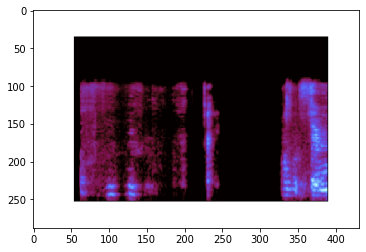

0.9577639102935791


In [ ]:
from tensorflow.keras.preprocessing import image
img_path = df_train.iloc[0,5] # fifth column is image_file
img = image.load_img(img_path, target_size=(288,432,3))
plt.imshow(img)
plt.show()

img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
prediction = model.predict(img_batch).tolist()
print(prediction[0][0])


# **Resample using distribution of probabilities.**

In [ ]:
#Reload best model so far comparing auc (Oversampling model)
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'

custom_objects = {"NPV": NPV, "Specificity": Specificity}
with keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_folder + "Covid_Model_oversampling.h5")

In [ ]:
#Add new column
df_train["Predicted_Prob"] = 'Nan'

from tensorflow.keras.preprocessing import image

def predict_prob(row):
  img_path = row.image_file
  img = image.load_img(img_path, target_size=(288,432,3))
  img_array = image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)
  prediction = model.predict(img_batch).tolist()
  row.Predicted_Prob = prediction[0][0]
  return row

df_train = df_train.apply(predict_prob, axis = 'columns')

df_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,age,gender,status,audio_file,image_file,source,cough_detected,Predicted_Prob
3420,6ea0f6b7-8110-4940-b848-0635be9b5978,29.0,male,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.9962,0.949207
3421,zM5GsorprLYElGQ3uJwnU0g0Fwr1,35.0,male,COVID-19,/content/drive/My Drive/Colab Notebooks/coswar...,/content/drive/My Drive/Colab Notebooks/coswar...,coswara,NaN,0.004331
3422,bx564wHvi9d0HyJTtdi0haZuU493,28.0,male,COVID-19,/content/drive/My Drive/Colab Notebooks/coswar...,/content/drive/My Drive/Colab Notebooks/coswar...,coswara,NaN,0.033578
3423,07e2f7e1-8e9b-4962-8701-fbe1224de7ef,28.0,male,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,1.0000,0.985296
3424,aeeb58ec-cefc-4d57-b2f5-db03cf502ae4,NaN,female,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.5410,0.880995
...,...,...,...,...,...,...,...,...,...
11396,4c21220c-04b3-4aa0-aac4-afede127213e,NaN,female,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.5809,0.927315
11397,285e7f6f-503a-41f0-ac3b-173433a8cf40,43.0,male,COVID-19,/content/drive/My Drive/Colab Notebooks/coughv...,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,1.0000,0.051105
11398,6478394b-6c6d-451a-8887-996a8e6d8fb8,27.0,male,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.9336,0.964138
11399,av4p9I9aBGfNYwrwkh4jEiEk1lE2,43.0,female,healthy,/content/drive/My Drive/Colab Notebooks/coswar...,/content/drive/My Drive/Colab Notebooks/coswar...,coswara,NaN,0.964002


# Draw a scatter graph.

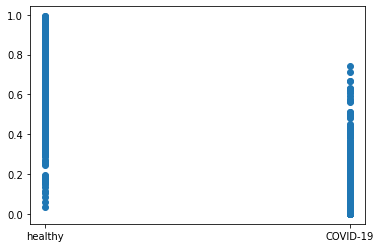

In [ ]:
x = df_train.loc[:,'status']
y = df_train.loc[:,'Predicted_Prob']
plt.scatter(x, y)
plt.show()

In [ ]:
df_train.to_csv(os.path.join(folder,'df_train_with_predicted_prob.csv'))

In [ ]:
df_train = pd.read_csv(os.path.join(folder,'df_train_with_predicted_prob.csv'), index_col = 0)
df_train

,id,age,gender,status,image_file,source,cough_detected,Predicted_Prob
3420,7ef296e3-b692-4907-830e-2a47798f4509,NaN,female,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.9954,0.806775
3421,7sW9NvDUCfWdCR5bPANiS05bqRc2,26.0,male,healthy,/content/drive/My Drive/Colab Notebooks/coswar...,coswara,NaN,0.966155
3422,ac4ea2db-4fff-4a7f-a5fe-3a9ade2f1020,NaN,female,COVID-19,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,1.0000,0.048167
3423,62e23b57-4964-44e0-b5c2-35e1c487d6f9,60.0,female,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.9693,0.958514
3424,dfb974e5-65b0-4ea8-b10b-a6349d7e0cbe,22.0,male,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.7407,0.989078
...,...,...,...,...,...,...,...,...
11396,7d0f7c10-c2fb-4a0b-8917-00c1bbfa9ba9,42.0,male,COVID-19,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,1.0000,0.048044
11397,5e26c5da-ab49-4df1-ba6f-eb9550877934,46.0,male,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,1.0000,0.933949
11398,VQVtmKC3HwVHbY1xMTued5OOP4E2,36.0,female,healthy,/content/drive/My Drive/Colab Notebooks/coswar...,coswara,NaN,0.903443
11399,e11c5a28-af63-4193-90aa-5ee8876c7fb3,55.0,female,healthy,/content/drive/My Drive/Colab Notebooks/coughv...,coughvid,0.9759,0.942117


# Remove healthy samples with a low predicted probability.

In [ ]:
df_healthy = df_train.loc[df_train.status == 'healthy']
df_covid = df_train.loc[df_train.status == 'COVID-19']

#Order healthy samples by Predicted_Prob before removing any
df_healthy = df_healthy.sort_values('Predicted_Prob',ascending=False)

#Select the same number of healthy samples as covid samples
df_healthy = df_healthy[:df_covid.shape[0]]

#Put healthy and covid back together in one dataframe and shuffle
df_resampled = pd.concat([df_healthy,df_covid])
df_resampled = df_resampled.sample(frac = 1)

print (df_resampled.shape)
print (df_healthy.shape)
print (df_covid.shape)

(1664, 9)
(832, 9)
(832, 9)


Review changed distribution

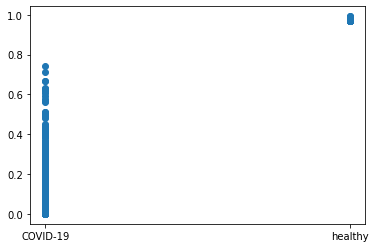

In [ ]:
x = df_resampled.loc[:,'status']
y = df_resampled.loc[:,'Predicted_Prob']
plt.scatter(x, y)
plt.show()

# Retrain Model.

In [ ]:
# Always run this cell.
precision = tf.keras.metrics.Precision(name = "precision")
recall = tf.keras.metrics.Recall(name = "recall")
specificity = Specificity(name = "specificity")
TP = tf.keras.metrics.TruePositives(name = "TP") 
FP = tf.keras.metrics.FalsePositives(name = "FP")
FN = tf.keras.metrics.FalseNegatives(name = "FN")
TN = tf.keras.metrics.TrueNegatives(name = "TN")
auc = tf.keras.metrics.AUC(name = "auc")
npv = NPV(name = "NPV")

In [ ]:
#Run this cell to create model or use next cell to load existing model.

batch_size = 50 #reduced batch size as there are less samples overall and datasets are now balanced.
img_height = 288
img_width = 432

# Rescaling of data moved to first layer of model
datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_data = datagen.flow_from_dataframe(df_resampled, x_col = "image_file", y_col = "status", 
                                               target_size = (img_height,img_width),  
                                               class_mode = "binary", batch_size = batch_size, 
                                               shuffle = True, validate_filenames = True)

val_data = datagen.flow_from_dataframe(df_val, x_col = "image_file", y_col = "status", 
                                           target_size = (img_height,img_width), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_data,  
    output_types = (tf.float32 , tf.float32) , # output dtype
    output_shapes = ([None , 288 , 432 , 3] , [None , ]) # The 'None' enables different batch sizes when training.
)

valid_dataset = tf.data.Dataset.from_generator(
    lambda: val_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

train_dataset = train_dataset.apply(tf.data.experimental.assert_cardinality(df_resampled.shape[0])) #Check these numbers with validated files found in data generator section.
valid_dataset = valid_dataset.apply(tf.data.experimental.assert_cardinality(df_val.shape[0]))


model_name = "Covid_Model_undersampling_2.h5" #Change name here for each new model

model = keras.Sequential([              

    #Rescale the pixel values (integers between 0 and 255) to [0,1]. 
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), 
    
    # Block One
    layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='same',
                  input_shape =[288,432,3]),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Two
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Three
    layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Four
    layers.Conv2D(filters=256, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Block Five
    layers.Conv2D(filters=512, kernel_size=3, activation='relu', padding='valid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size = (2,2)),

    # Head
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
])

model._name= model_name[:-3]

model_plots_folder = os.path.join(folder,'model_plots')

# Save model summaries to a text file.
with open(os.path.join(model_plots_folder,'Model_summaries.txt'), 'a') as f:
    with redirect_stdout(f):
        model.summary()

# Save model plots to individual png files.
plot_model(
    model,
    to_file=(os.path.join(model_plots_folder, model_name[:-3] + ".png")),
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

model.summary()
plot_model(model, show_shapes=True)

es_callback = EarlyStopping(monitor = 'val_auc',
                            mode='max',
                            min_delta = 0.01,
                            patience = 10,
                            restore_best_weights = True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
    loss='binary_crossentropy',
    metrics=[TP, FP, FN, TN, 
             npv, specificity, 
             recall, auc
             ]
)

model_folder = '/content/drive/My Drive/Colab Notebooks/models/'
initial_weights = os.path.join(model_folder, 'initial_weights')
model.load_weights(initial_weights) #Initial weights created in colab notebook: Detecting_COVID_CNN_bias_initializer.

history = model.fit(
    train_dataset,
    validation_data=valid_dataset,
    callbacks = [es_callback],
    epochs = 30,
    steps_per_epoch=len(train_dataset) // batch_size,
    validation_steps=len(valid_dataset) // batch_size)

model.save(model_folder + model_name)


Found 1664 validated image filenames belonging to 2 classes.
Found 3420 validated image filenames belonging to 2 classes.
Model: "Covid_Model_undersampling_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 288, 432, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 288, 432, 32)      896       
                                                                 
 batch_normalization_10 (Bat  (None, 288, 432, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 144, 216, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 142, 214, 64)

In [ ]:
#Reload model created in previous cell if previous cell has been run before.
model_folder = '/content/drive/My Drive/Colab Notebooks/models/'

custom_objects = {"NPV": NPV, "Specificity": Specificity}
with keras.utils.custom_object_scope(custom_objects):
    model = tf.keras.models.load_model(model_folder + "Covid_Model_undersampling_2.h5")

# Retest Model.

In [ ]:
# Import Test dataframe
df_test = pd.read_csv(os.path.join(folder, 'df_test.csv'), index_col=0)

#Rescale images in the same way as for train and validation sets
test_data = datagen.flow_from_dataframe(df_test, x_col = "image_file", y_col = "status", 
                                           target_size = (288,432), 
                                           class_mode = "binary", batch_size = batch_size, 
                                           shuffle = False, validate_filenames = True)

#Create dataset
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_data, 
    output_types = (tf.float32 , tf.float32), 
    output_shapes = ([None , 288 , 432 , 3] , [None , ])
)

#Assert cardinality so the length can be used.
test_dataset = test_dataset.apply(tf.data.experimental.assert_cardinality(df_test.shape[0]))

_,TP,FP,FN,TN, Spec, npv, Recall, AUC = model.evaluate(test_dataset, steps = df_test.shape[0]//batch_size)
print('Confusion Matrix: ', TP, FP, FN, TN)
print('Test NPV: %.4f' % npv)
print('Test Specificity: %.4f' % Spec)
print('Test Recall: %.4f' % Recall)
print('Test ROC-AUC: %.4f' % AUC)

Found 1000 validated image filenames belonging to 2 classes.
20/20 [==============================] - 5s 251ms/step - loss: 2.3963 - TP: 0.0000e+00 - FP: 0.0000e+00 - FN: 886.0000 - TN: 114.0000 - NPV: 0.1140 - specificity: 1.0000 - recall: 0.0000e+00 - auc: 0.4851
Confusion Matrix:  0.0 0.0 886.0 114.0
Test NPV: 1.0000
Test Specificity: 0.1140
Test Recall: 0.0000
Test ROC-AUC: 0.4851
